 #  A Whale off the Port(folio)
 ---

 In this assignment, you'll get to use what you've learned this week to evaluate the performance among various algorithmic, hedge, and mutual fund portfolios and compare them against the S&P TSX 60 Index.

In [1]:
# Initial imports
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path

%matplotlib inline

# Data Cleaning

In this section, you will need to read the CSV files into DataFrames and perform any necessary data cleaning steps. After cleaning, combine all DataFrames into a single DataFrame.

Files:

* `whale_returns.csv`: Contains returns of some famous "whale" investors' portfolios.

* `algo_returns.csv`: Contains returns from the in-house trading algorithms from Harold's company.

* `sp_tsx_history.csv`: Contains historical closing prices of the S&P TSX 60 Index.

## Whale Returns

Read the Whale Portfolio daily returns and clean the data.

In [2]:
# Reading whale returns
whale_returns_csv = 'Resources/whale_returns.csv'
whale_returns = pd.read_csv(whale_returns_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)

In [3]:
# Count nulls
whale_returns.isnull().sum()

SOROS FUND MANAGEMENT LLC      1
PAULSON & CO.INC.              1
TIGER GLOBAL MANAGEMENT LLC    1
BERKSHIRE HATHAWAY INC         1
dtype: int64

In [4]:
# Drop nulls
whale_returns.dropna(inplace=True)

## Algorithmic Daily Returns

Read the algorithmic daily returns and clean the data.

In [5]:
# Reading algorithmic returns
algo_returns_csv = 'Resources/algo_returns.csv'
algo_returns = pd.read_csv(algo_returns_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)

In [6]:
# Count nulls
algo_returns.isnull().sum()

Algo 1    0
Algo 2    6
dtype: int64

In [7]:
# Drop nulls
algo_returns.dropna(inplace=True)

## S&P TSX 60 Returns

Read the S&P TSX 60 historic closing prices and create a new daily returns DataFrame from the data. 

In [8]:
# Reading S&P TSX 60 Closing Prices
sp_tsx_history_csv = 'Resources/sp_tsx_history.csv'
sp_tsx_history = pd.read_csv(sp_tsx_history_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)

In [9]:
# Check Data Types
sp_tsx_history.dtypes

Close    object
dtype: object

In [10]:
# Fix Data Types
# Replace all non-numeric characters in 'Close' column with an empty string
sp_tsx_history['Close'] = sp_tsx_history['Close'].replace('[^0-9\.]', '', regex=True)
# Convert 'Close' column to numeric datatype
sp_tsx_history['Close'] = pd.to_numeric(sp_tsx_history['Close'])

In [11]:
# Calculate Daily Returns
sp_tsx_returns = sp_tsx_history.pct_change()
sp_tsx_returns.head()

,Close
Date,
2012-10-01,NaN
2012-10-02,0.001701
2012-10-03,-0.002563
2012-10-04,0.007137
2012-10-05,-0.002305


In [12]:
# Drop nulls
sp_tsx_returns.dropna(inplace=True)

In [13]:
# Rename `Close` Column to be specific to this portfolio.
sp_tsx_returns.columns = ["S&P TSX"]

## Combine Whale, Algorithmic, and S&P TSX 60 Returns

In [14]:
# Join Whale Returns, Algorithmic Returns, and the S&P TSX 60 Returns into a single DataFrame with columns for each portfolio's returns.
all_returns = pd.concat([whale_returns, algo_returns, sp_tsx_returns], axis="columns", join="inner")

---

# Conduct Quantitative Analysis

In this section, you will calculate and visualize performance and risk metrics for the portfolios.

## Performance Anlysis

#### Calculate and Plot the daily returns.

<AxesSubplot:xlabel='Date'>

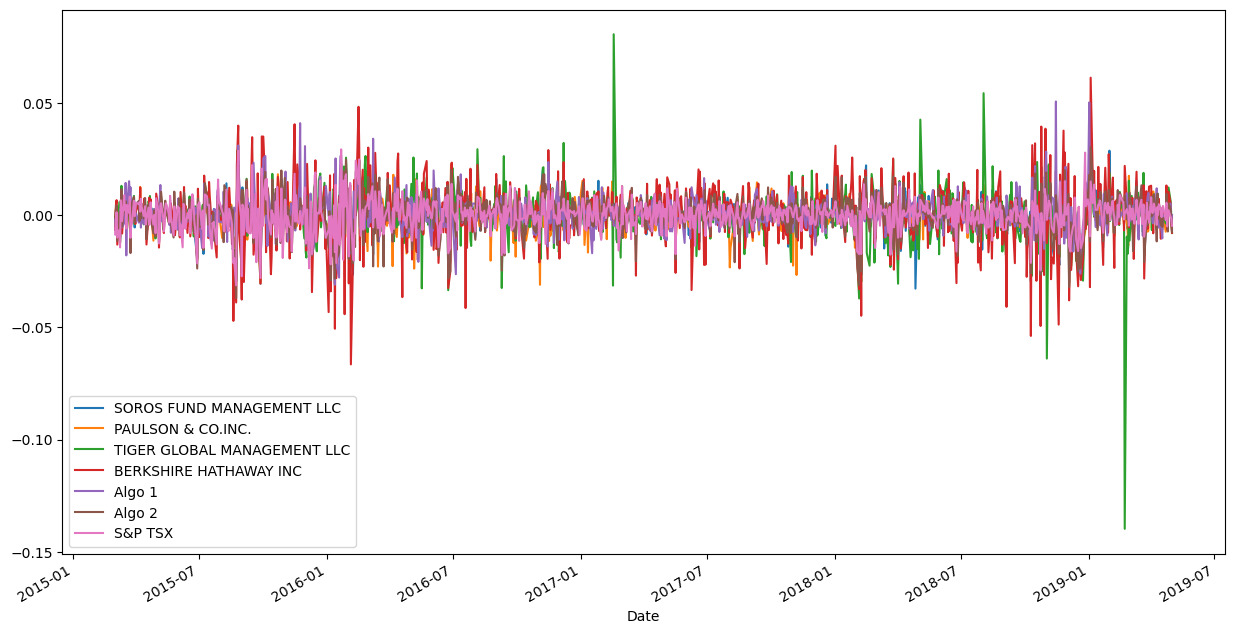

In [15]:
# Plot daily returns of all portfolios
all_returns.plot(figsize=(15, 8))

#### Calculate and Plot cumulative returns.

<AxesSubplot:xlabel='Date'>

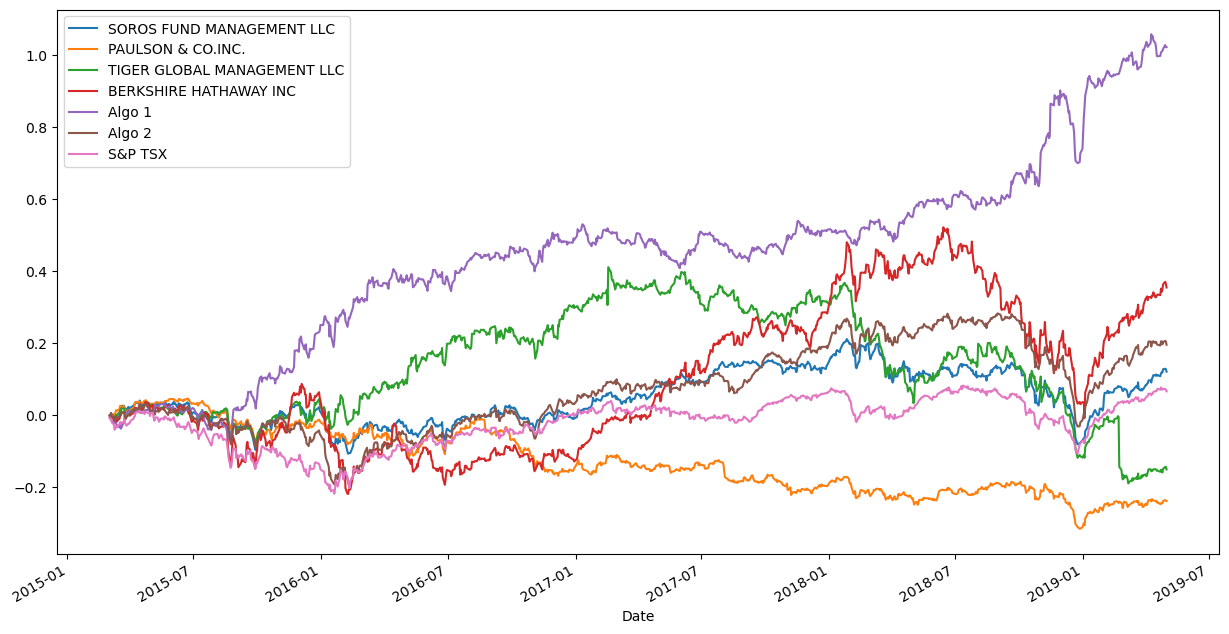

In [16]:
# Calculate cumulative returns of all portfolios
cumulative_returns = (1 + all_returns).cumprod() - 1
# Plot cumulative returns
cumulative_returns.plot(figsize=(15, 8))

---

## Risk Analysis

Determine the _risk_ of each portfolio:

1. Create a box plot for each portfolio. 
2. Calculate the standard deviation for all portfolios.
4. Determine which portfolios are riskier than the S&P TSX 60.
5. Calculate the Annualized Standard Deviation.

### Create a box plot for each portfolio


<AxesSubplot:>

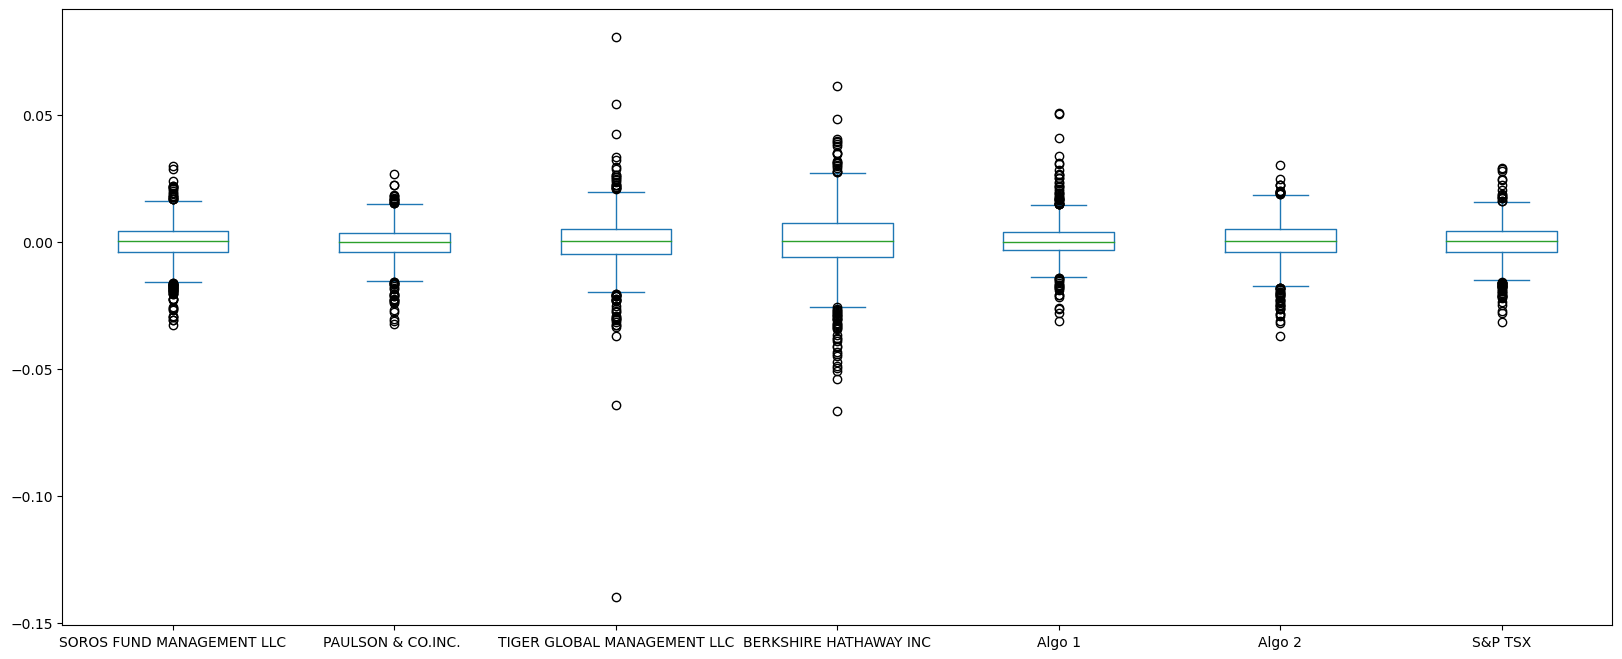

In [17]:
# Box plot to visually show risk
all_returns.plot(kind="box", figsize=(20, 8))

### Calculate Standard Deviations

In [18]:
# Calculate the daily standard deviations of all portfolios
portfolio_std = all_returns.std()

### Determine which portfolios are riskier than the S&P TSX 60

In [19]:
# Calculate the daily standard deviation of S&P TSX 60
riskier_portfolios = portfolio_std[portfolio_std > portfolio_std["S&P TSX"]]

# Determine which portfolios are riskier than the S&P TSX 60
for portfolio in riskier_portfolios.index:
    print(portfolio)

SOROS FUND MANAGEMENT LLC
TIGER GLOBAL MANAGEMENT LLC
BERKSHIRE HATHAWAY INC
Algo 1
Algo 2


### Calculate the Annualized Standard Deviation

In [20]:
# Calculate the annualized standard deviation (252 trading days)
annualized_std = portfolio_std * np.sqrt(252)

---

## Rolling Statistics

Risk changes over time. Analyze the rolling statistics for Risk and Beta. 

1. Calculate and plot the rolling standard deviation for all portfolios using a 21-day window.
2. Calculate the correlation between each stock to determine which portfolios may mimick the S&P TSX 60.
3. Choose one portfolio, then calculate and plot the 60-day rolling beta for it and the S&P TSX 60.

### Calculate and plot rolling `std` for all portfolios with 21-day window

<AxesSubplot:xlabel='Date'>

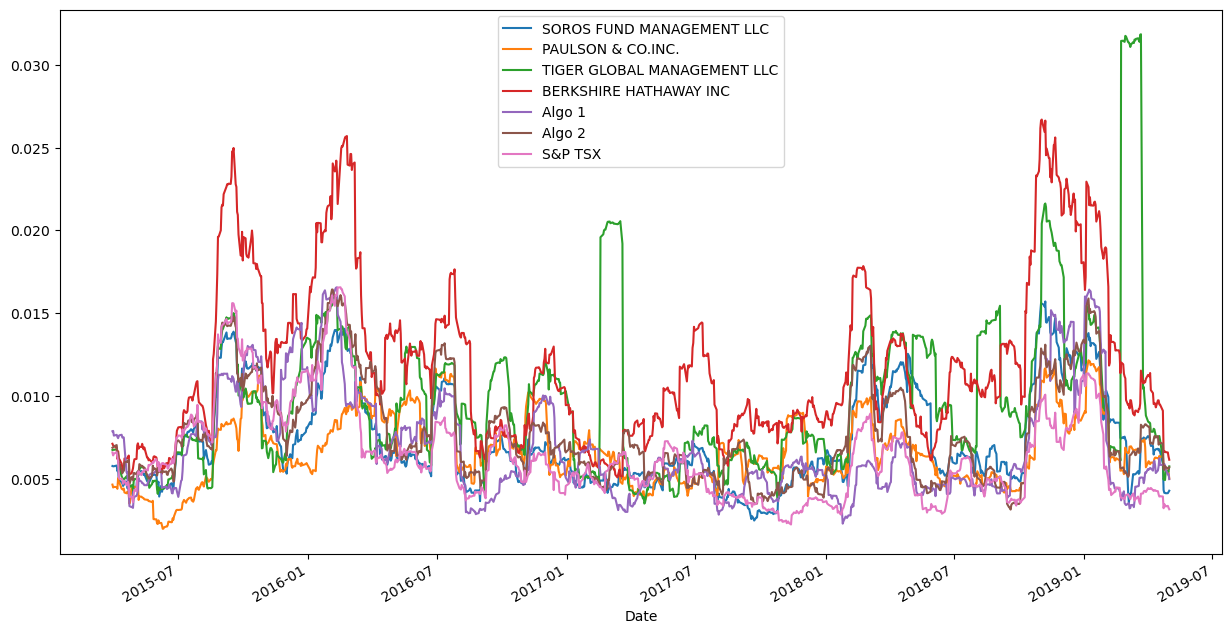

In [21]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window
all_returns.rolling(window=21).std().plot(figsize=(15, 8))

### Calculate and plot the correlation

In [22]:
# Calculate the correlation
correlation = all_returns.corr()
# Display de correlation matrix
correlation.style.background_gradient(cmap='coolwarm')

,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX
SOROS FUND MANAGEMENT LLC,1.000000,0.697076,0.560964,0.750181,0.313795,0.826667,0.673930
PAULSON & CO.INC.,0.697076,1.000000,0.433034,0.540033,0.266363,0.674015,0.486511
TIGER GLOBAL MANAGEMENT LLC,0.560964,0.433034,1.000000,0.423524,0.161236,0.506689,0.440583
BERKSHIRE HATHAWAY INC,0.750181,0.540033,0.423524,1.000000,0.289378,0.684609,0.557250
Algo 1,0.313795,0.266363,0.161236,0.289378,1.000000,0.285455,0.310276
Algo 2,0.826667,0.674015,0.506689,0.684609,0.285455,1.000000,0.737370
S&P TSX,0.673930,0.486511,0.440583,0.557250,0.310276,0.737370,1.000000


### Calculate and Plot Beta for a chosen portfolio and the S&P 60 TSX

<AxesSubplot:title={'center':'60-Day Rolling Beta: Algo 1 vs S&P TSX 60'}, xlabel='Date'>

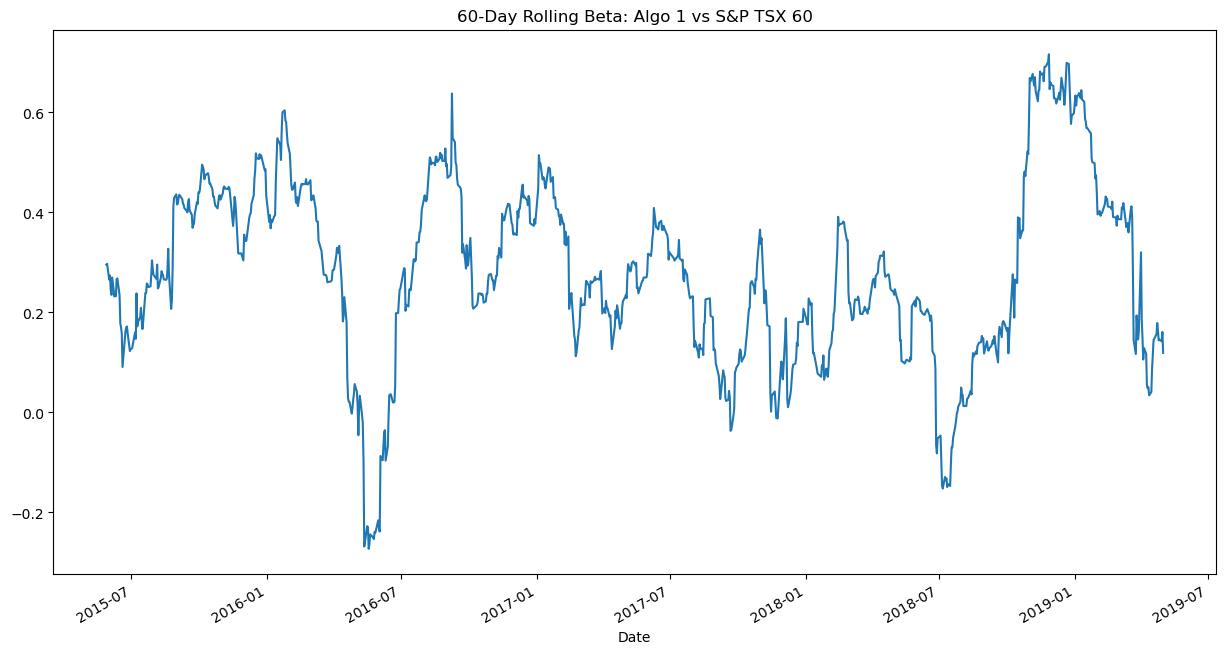

In [23]:
# Calculate covariance of a single portfolio
covariance = all_returns['Algo 1'].rolling(window=60).cov(all_returns['S&P TSX'])

# Calculate variance of S&P TSX
variance = all_returns['S&P TSX'].rolling(window=60).var()

# Computing beta
beta = covariance / variance

# Plot beta trend
beta.plot(figsize=(15, 8), title='60-Day Rolling Beta: Algo 1 vs S&P TSX 60')

## Rolling Statistics Challenge: Exponentially Weighted Average 

An alternative way to calculate a rolling window is to take the exponentially weighted moving average. This is like a moving window average, but it assigns greater importance to more recent observations. Try calculating the [`ewm`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html) with a 21-day half life for each portfolio, using standard deviation (`std`) as the metric of interest.

<AxesSubplot:title={'center':'Exponentially Weighted Average - Standard Deviation'}, xlabel='Date'>

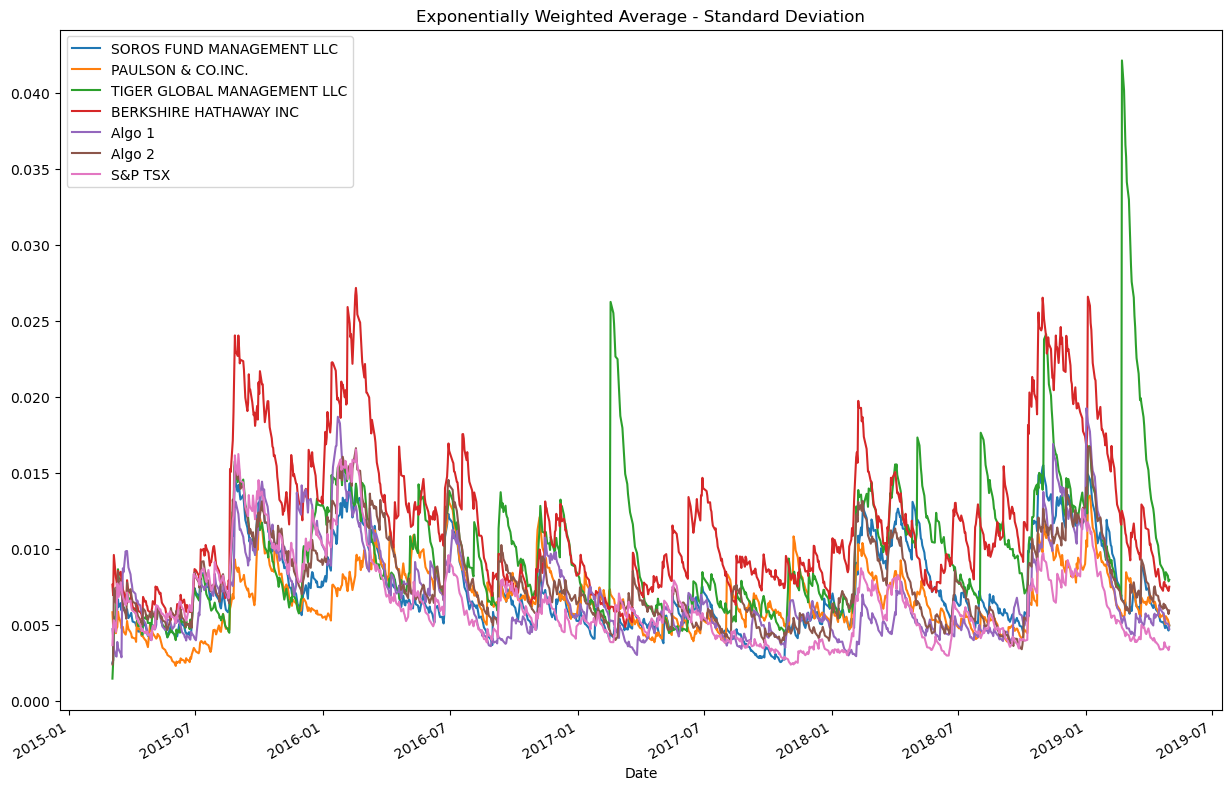

In [24]:
# Use `ewm` to calculate the rolling window
ewm_std = all_returns.ewm(span=21).std()
ewm_std.plot(figsize=(15, 10), title='Exponentially Weighted Average - Standard Deviation')

---

# Sharpe Ratios
In reality, investment managers and thier institutional investors look at the ratio of return-to-risk, and not just returns alone. After all, if you could invest in one of two portfolios, and each offered the same 10% return, yet one offered lower risk, you'd take that one, right?

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [25]:
# Annualized Sharpe Ratios
sharpe_ratios = all_returns.mean() * 252 / (all_returns.std() * np.sqrt(252))

<AxesSubplot:title={'center':'Sharpe Ratios'}>

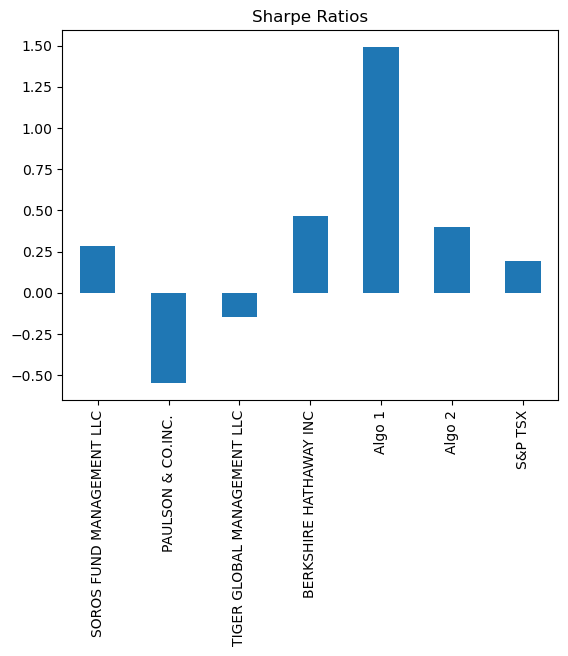

In [26]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios.plot(kind='bar', title='Sharpe Ratios')

### Determine whether the algorithmic strategies outperform both the market (S&P TSX 60) and the whales portfolios.

Write your answer here! Based on the Sharpe Ratios, Algorithmic strategy 1 (Algo 1) outperforms the S&P TSX 60 and all the whale portfolios.

---

# Create Custom Portfolio

In this section, you will build your own portfolio of stocks, calculate the returns, and compare the results to the Whale Portfolios and the S&P TSX 60. 

1. Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.
2. Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock.
3. Join your portfolio returns to the DataFrame that contains all of the portfolio returns.
4. Re-run the performance and risk analysis with your portfolio to see how it compares to the others.
5. Include correlation analysis to determine which stocks (if any) are correlated.

## Choose 3-5 custom stocks with at last 1 year's worth of historic prices and create a DataFrame of the closing prices and dates for each stock.

In [27]:
# Reading data from 1st stock
shop_csv = 'Resources/shop_historical.csv'
SHOP = pd.read_csv(shop_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)

In [28]:
# Reading data from 2nd stock
otex_csv = 'Resources/otex_historical.csv'
OTEX = pd.read_csv(otex_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)

In [29]:
# Reading data from 3rd stock
l_csv = 'Resources/l_historical.csv'
L = pd.read_csv(l_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)

In [30]:
# Combine all stocks in a single DataFrame
stocks = pd.concat([SHOP, OTEX, L], axis="columns", join="inner")

In [31]:
# Reset Date index
stocks.index = stocks.index.normalize()

In [32]:
# Reorganize portfolio data by having a column per symbol
# Get the column names of the 1st, 3rd, and 5th columns
columns_to_drop = stocks.columns[::2]

# Drop the 1st, 3rd, and 5th columns
stocks_dropped = stocks.drop(columns_to_drop, axis=1)

# Define the new column names
new_columns = ['SHOP', 'OTEX', 'L']

# Set the new column names using the set_axis method
stocks_clean = stocks_dropped.set_axis(new_columns, axis=1)

# Display the modified DataFrame
stocks_clean.head()

,SHOP,OTEX,L
Date,,,
2018-01-02,132.06,43.58,57.99
2018-01-03,135.15,43.07,57.41
2018-01-04,137.46,42.91,57.42
2018-01-05,137.26,42.57,57.42
2018-01-08,139.51,42.16,56.86


In [33]:
# Calculate daily returns
stocks_returns = stocks_clean.pct_change()
# Drop NAs
stocks_returns.dropna(inplace=True)
# Display sample data
stocks_returns.head()

,SHOP,OTEX,L
Date,,,
2018-01-03,0.023398,-0.011703,-0.010002
2018-01-04,0.017092,-0.003715,0.000174
2018-01-05,-0.001455,-0.007924,0.000000
2018-01-08,0.016392,-0.009631,-0.009753
2018-01-09,-0.011254,-0.000712,0.008969


## Calculate the weighted returns for the portfolio assuming an equal number of shares for each stock

In [34]:
# Set weights
weights = [1/3, 1/3, 1/3]
# Calculate portfolio return
portfolio_returns = stocks_returns.dot(weights)
# Display sample data
portfolio_returns.head()

Date
2018-01-03    0.000565
2018-01-04    0.004517
2018-01-05   -0.003126
2018-01-08   -0.000997
2018-01-09   -0.000999
dtype: float64

## Join your portfolio returns to the DataFrame that contains all of the portfolio returns

In [35]:
# Join your returns DataFrame to the original returns DataFrame
joined_df = pd.merge(stocks_returns, all_returns, left_index=True, right_index=True, how='left')

In [36]:
joined_df.head()

,SHOP,OTEX,L,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX
Date,,,,,,,,,,
2018-01-03,0.023398,-0.011703,-0.010002,0.004658,0.000027,0.001979,0.005676,-0.000890,0.008175,0.003774
2018-01-04,0.017092,-0.003715,0.000174,-0.000914,0.004196,0.010743,0.004065,-0.000914,0.004294,0.002528
2018-01-05,-0.001455,-0.007924,0.000000,0.004072,0.000823,0.000737,0.022023,-0.003839,0.006405,-0.003869
2018-01-08,0.016392,-0.009631,-0.009753,0.004473,-0.003739,0.005085,0.003435,0.001653,0.000658,-0.001944
2018-01-09,-0.011254,-0.000712,0.008969,-0.001028,0.000872,0.001789,0.000708,-0.001004,-0.002091,0.000097


In [37]:
# Only compare dates where return data exists for all the stocks (drop NaNs)
joined_df.dropna(inplace=True)

## Re-run the risk analysis with your portfolio to see how it compares to the others

### Calculate the Annualized Standard Deviation

In [38]:
# Calculate the annualized `std`
annualized_std_custom = joined_df.std() * np.sqrt(252)

### Calculate and plot rolling `std` with 21-day window

[]

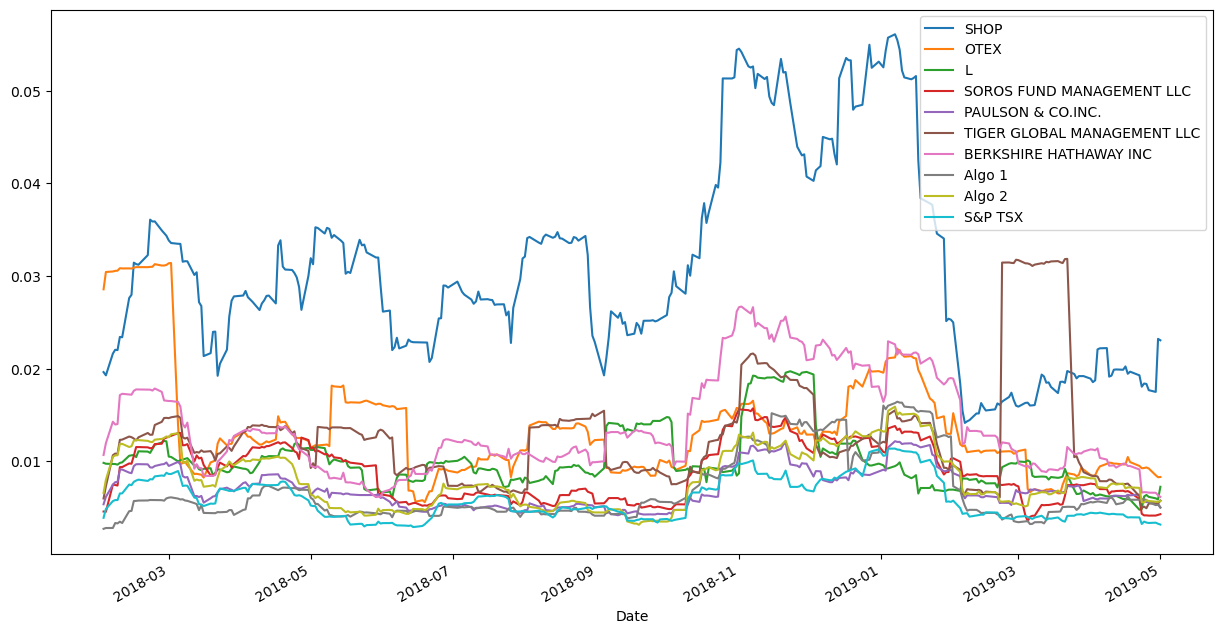

In [214]:
# Calculate rolling standard deviation
rolling_std_custom = joined_df.rolling(window=21).std().plot(figsize=(15, 8))
# Plot rolling standard deviation
rolling_std_custom.plot(figsize=(15, 10), title='21-Day Rolling Standard Deviation - Custom Portfolio')

### Calculate and plot the correlation

In [39]:
# Calculate and plot the correlation
new_correlation = joined_df.corr()
new_correlation.style.background_gradient(cmap='coolwarm')

,SHOP,OTEX,L,SOROS FUND MANAGEMENT LLC,PAULSON & CO.INC.,TIGER GLOBAL MANAGEMENT LLC,BERKSHIRE HATHAWAY INC,Algo 1,Algo 2,S&P TSX
SHOP,1.000000,0.395357,0.113386,0.508507,0.317837,0.183726,0.637107,0.206226,0.507364,0.462264
OTEX,0.395357,1.000000,0.174320,0.383971,0.320638,0.250926,0.413242,0.108323,0.426084,0.450590
L,0.113386,0.174320,1.000000,0.192009,0.164145,0.339680,0.130815,0.099106,0.168862,0.338382
SOROS FUND MANAGEMENT LLC,0.508507,0.383971,0.192009,1.000000,0.764174,0.526710,0.782414,0.305525,0.834431,0.686681
PAULSON & CO.INC.,0.317837,0.320638,0.164145,0.764174,1.000000,0.536534,0.647407,0.320568,0.797494,0.623728
TIGER GLOBAL MANAGEMENT LLC,0.183726,0.250926,0.339680,0.526710,0.536534,1.000000,0.384316,0.130845,0.485258,0.438781
BERKSHIRE HATHAWAY INC,0.637107,0.413242,0.130815,0.782414,0.647407,0.384316,1.000000,0.294696,0.783254,0.649817
Algo 1,0.206226,0.108323,0.099106,0.305525,0.320568,0.130845,0.294696,1.000000,0.321837,0.284789
Algo 2,0.507364,0.426084,0.168862,0.834431,0.797494,0.485258,0.783254,0.321837,1.000000,0.754326
S&P TSX,0.462264,0.450590,0.338382,0.686681,0.623728,0.438781,0.649817,0.284789,0.754326,1.000000


### Calculate and Plot the 60-day Rolling Beta for Your Portfolio compared to the S&P 60 TSX

<AxesSubplot:title={'center':'60-Day Rolling Beta: OTEX vs S&P TSX 60'}, xlabel='Date'>

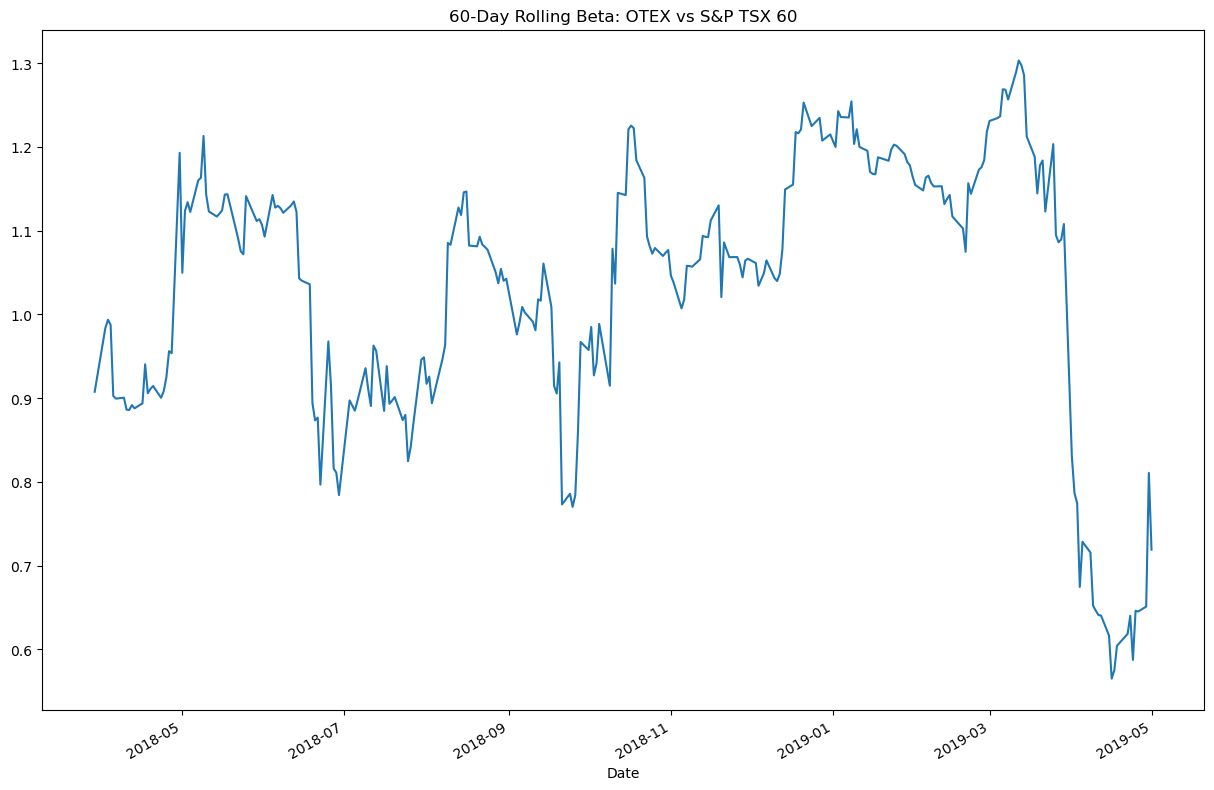

In [46]:
# Calculate and plot Beta
# Calculate Beta
joined_covariance = joined_df['OTEX'].rolling(window=60).cov(joined_df['S&P TSX'])
joined_variance = joined_df['S&P TSX'].rolling(window=60).var()
# Plot Beta
joined_beta = joined_covariance / joined_variance
joined_beta.plot(figsize=(15, 10), title='60-Day Rolling Beta: OTEX vs S&P TSX 60')

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [47]:
# Calculate Annualized Sharpe Ratios
sharpe_ratios_custom = joined_df.mean() * 252 / (joined_df.std() * np.sqrt(252))

<AxesSubplot:title={'center':'Sharpe Ratios - Including Custom Portfolio'}>

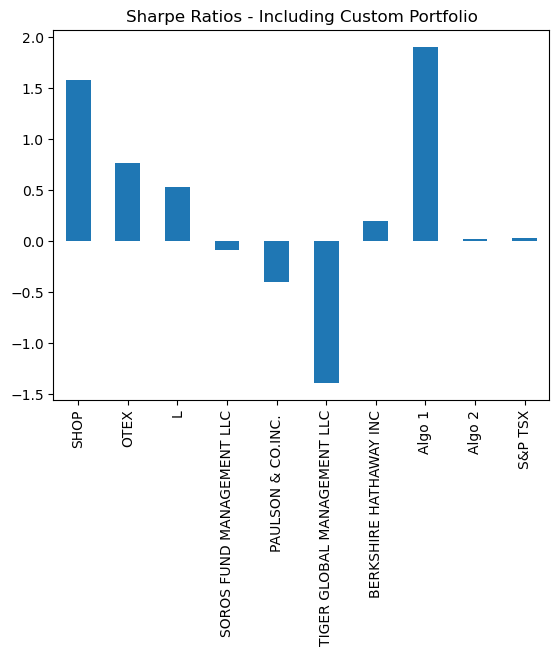

In [48]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios_custom.plot(kind='bar', title='Sharpe Ratios - Including Custom Portfolio')

### How does your portfolio do?

Write your answer here!

Based on the Sharpe Ratios, the custom portfolio performs better than the S&P TSX 60, SOROS FUND MANAGEMENT LLC, PAULSON & CO.INC., TIGER GLOBAL MANAGEMENT LLC., BERKSHIRE HATHAWAY INC & Algorithmic Strategy 2. However, it underperforms compared to Algorithmic Strategy 1.